* Compare minimum salinity value, location, fresh water amount between ferry observation, nowcast and new model results.

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools)
from salishsea_tools.nowcast import figures
from datetime import datetime, timedelta
from pylab import *
from sklearn import linear_model
from glob import glob
from IPython.core.display import HTML
from salishsea_tools.nowcast import figures
import matplotlib.pyplot as plt
import scipy.io as sio
import netCDF4 as nc
import numpy as np
import math
import os
import datetime
%matplotlib inline

In [2]:
import sys
sys.path.append('/ocean/jieliu/research/meopar/analysis/jie/salinity_comparison/')
import salinity

In [3]:
paths = {'nowcast': '/data/dlatorne/MEOPAR/SalishSea/nowcast/',
        'longerresult': '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/',
        'widenresult': '/data/jieliu/MEOPAR/river-treatment/24nor_NW/' }

In [4]:
run_date = datetime.datetime(2015,6,16)
# Results dataset location
results_home = paths['longerresult']
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [5]:
grid_T_hr = salinity.results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
#filepath_name = salinity.date(run_date.year,run_date.month, run_date.day,\
                              #run_date.day,run_date.day, paths['longerresult'],'1h','grid_T') 

In [6]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 1
sal_hr_1 = np.ma.masked_values(sal_hr[t, z], 0)
sal_hr_ave = np.ma.masked_values(np.mean(sal_hr[t, 0:3], axis = 0), 0)

# salinity data on June 16

In [7]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,16)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150615.mat')
salinity16_min_obs, lon16_min_obs, salinity16_min_15,\
lon16_min_15, salinity16_min_ave, lon16_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [9]:
## for observation and new model result
results_home = paths['longerresult']
salinity16_min_obs, lon16_min_obs, salinity16_min_15,\
lon16_min_15_new, salinity16_min_ave_new, lon16_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 17

In [10]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,17)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150616.mat')
salinity17_min_obs, lon17_min_obs, salinity17_min_15,\
lon17_min_15, salinity17_min_ave, lon17_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [11]:
## for observation and new model result
results_home = paths['longerresult']
salinity17_min_obs, lon17_min_obs, salinity17_min_15,\
lon17_min_15_new, salinity17_min_ave_new, lon17_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 18

In [12]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,18)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150617.mat')
salinity16_min_obs, lon18_min_obs, salinity18_min_15,\
lon18_min_15, salinity18_min_ave, lon18_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [13]:
## for observation and new model result
results_home = paths['longerresult']
salinity18_min_obs, lon18_min_obs, salinity18_min_15,\
lon18_min_15_new, salinity18_min_ave_new, lon18_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

* ferry data from June 19 to 21 are not usable

# salinity data on June 22

In [14]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,22)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150621.mat')
salinity22_min_obs, lon22_min_obs, salinity22_min_15,\
lon22_min_15, salinity22_min_ave, lon22_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [15]:
## for observation and new model result
results_home = paths['longerresult']
salinity22_min_obs, lon22_min_obs, salinity22_min_15,\
lon22_min_15_new, salinity22_min_ave_new, lon22_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 23

In [18]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,23)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150622.mat')
salinity23_min_obs, lon23_min_obs, salinity23_min_15,\
lon23_min_15, salinity23_min_ave, lon23_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [19]:
## for observation and new model result
results_home = paths['longerresult']
salinity23_min_obs, lon23_min_obs, salinity23_min_15,\
lon23_min_15_new, salinity23_min_ave_new, lon23_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 24

In [20]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,24)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150623.mat')
salinity24_min_obs, lon24_min_obs, salinity24_min_15,\
lon24_min_15, salinity24_min_ave, lon24_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [21]:
## for observation and new model result
results_home = paths['longerresult']
salinity24_min_obs, lon24_min_obs, salinity24_min_15,\
lon24_min_15_new, salinity24_min_ave_new, lon24_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 25

In [22]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,25)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150624.mat')
salinity25_min_obs, lon25_min_obs, salinity25_min_15,\
lon25_min_15, salinity25_min_ave, lon25_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [23]:
## for observation and new model result
results_home = paths['longerresult']
salinity25_min_obs, lon25_min_obs, salinity25_min_15,\
lon25_min_15_new, salinity25_min_ave_new, lon25_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 26

In [24]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,26)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150625.mat')
salinity26_min_obs, lon26_min_obs, salinity26_min_15,\
lon26_min_15, salinity26_min_ave, lon26_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [25]:
## for observation and new model result
results_home = paths['longerresult']
salinity26_min_obs, lon26_min_obs, salinity26_min_15,\
lon26_min_15_new, salinity26_min_ave_new, lon26_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 27

In [26]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,27)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150626.mat')
salinity27_min_obs, lon27_min_obs, salinity27_min_15,\
lon27_min_15, salinity27_min_ave, lon27_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [27]:
## for observation and new model result
results_home = paths['longerresult']
salinity27_min_obs, lon27_min_obs, salinity27_min_15,\
lon27_min_15_new, salinity27_min_ave_new, lon27_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 28

In [28]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,28)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150627.mat')
salinity28_min_obs, lon28_min_obs, salinity28_min_15,\
lon28_min_15, salinity28_min_ave, lon28_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [29]:
## for observation and new model result
results_home = paths['longerresult']
salinity28_min_obs, lon28_min_obs, salinity28_min_15,\
lon28_min_15_new, salinity28_min_ave_new, lon28_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

# salinity data on June 29

In [30]:
## for observation and nowcast
run_date = datetime.datetime(2015,6,29)
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150628.mat')
salinity29_min_obs, lon29_min_obs, salinity29_min_15,\
lon29_min_15, salinity29_min_ave, lon29_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [31]:
## for observation and new model result
results_home = paths['longerresult']
salinity29_min_obs, lon29_min_obs, salinity29_min_15,\
lon29_min_15_new, salinity29_min_ave_new, lon29_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

* combine daily minimum salinity value and location data

In [46]:
## for observation
min_obs_value = [salinity16_min_obs, salinity17_min_obs, salinity18_min_obs,\
                salinity22_min_obs,salinity23_min_obs,salinity24_min_obs,\
                salinity25_min_obs,salinity26_min_obs,salinity27_min_obs,\
                salinity28_min_obs,salinity28_min_obs]

min_obs_lon = [lon16_min_obs, lon17_min_obs, lon18_min_obs, lon22_min_obs,\
              lon23_min_obs, lon24_min_obs, lon25_min_obs, lon26_min_obs,\
              lon27_min_obs, lon28_min_obs, lon29_min_obs]

In [ ]:
## for nowcast 1.5m & average 3m result

In [ ]:
## for new result with 1.5m & average 3m result

In [49]:
time = [1,2,3,4,5,6,7,8,9,10, 11]

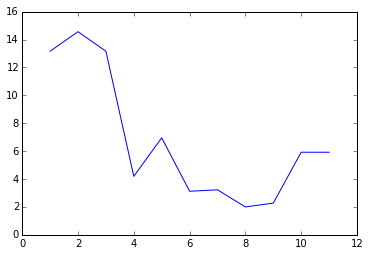

In [50]:
plt.plot(time, min_obs_value)